In [3]:
import sys
sys.path.append("/Users/claire/Desktop/Stuff-/codes/dissertation/cxr/rgrg/src/full_model")
sys.path.append("/Users/claire/Desktop/Stuff-/codes/dissertation/cxr/rgrg/src")
# import sys
sys.path.append("/Users/claire/Desktop/Stuff-/codes/dissertation/cxr/rgrg/")

from full_model.train_full_model import *
from full_model.generate_reports_for_images import *
from full_model.test_set_evaluation import *
import matplotlib.pyplot as plt

In [2]:

model = get_model()
print("Model instantiated.")

raw_test_dataset, raw_test_2_dataset = get_dataset()
tokenizer = get_tokenizer()
tokenized_test_dataset, tokenized_test_2_dataset = get_tokenized_dataset(tokenizer, raw_test_dataset, raw_test_2_dataset)
test_transforms = get_transforms()
test_transforms = get_transforms()
test_dataset_complete = CustomDataset("test", tokenized_test_dataset, test_transforms, log)
test_2_dataset_complete = CustomDataset("test", tokenized_test_2_dataset, test_transforms, log)
test_loader, test_2_loader = get_data_loaders(tokenizer, test_dataset_complete, test_2_dataset_complete)
print("Test dataloaders instantiated.")




Model instantiated.


[WARNING]: Parameter 'function'=<function get_tokenized_dataset.<locals>.tokenize_function at 0x2b89f2280> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/30804 [00:00<?, ?ex/s]

  0%|          | 0/1173 [00:00<?, ?ex/s]

Test dataloaders instantiated.


# visualization of box

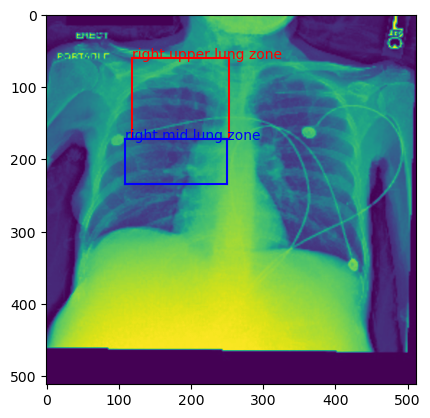

In [56]:

  
REGION_LIST = ['right lung', 'right upper lung zone', 'right mid lung zone', 'right lower lung zone', 'right hilar structures', 'right apical zone', 'right costophrenic angle', 'right hemidiaphragm', 'left lung', 'left upper lung zone', 'left mid lung zone', 'left lower lung zone', 'left hilar structures', 'left apical zone', 'left costophrenic angle', 'left hemidiaphragm', 'trachea', 'spine', 'right clavicle', 'left clavicle', 'aortic arch', 'mediastinum', 'upper mediastinum', 'svc', 'cardiac silhouette', 'cavoatrial junction', 'right atrium', 'carina', 'abdomen']

def viz_image(image_ind, box_ind, point=None, target_box=None):
    image= test_loader.dataset[image_ind]['image']
    image = image.squeeze(0)
    box = test_loader.dataset[image_ind]['bbox_coordinates']
    # if box_ind is a int
    if isinstance(box_ind, int):
        box_coords = box[box_ind]
        box_coords = [x * 2 for x in box_coords]
        # show image and box and label on image1
        plt.imshow(image)
        plt.plot([box_coords[0], box_coords[0]], [box_coords[1], box_coords[3]], color='red')
        plt.plot([box_coords[2], box_coords[2]], [box_coords[1], box_coords[3]], color='red')
        plt.plot([box_coords[0], box_coords[2]], [box_coords[1], box_coords[1]], color='red')
        plt.plot([box_coords[0], box_coords[2]], [box_coords[3], box_coords[3]], color='red')
        plt.text(box_coords[0], box_coords[1], REGION_LIST[box_ind], color='red')
        
    else:
        image = image.squeeze(0)
        colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black']
        for ind, i in enumerate(box_ind):
            box_coords = box[i]
            box_coords = [x * 2 for x in box_coords]
            # show image and box and label on image1
            plt.imshow(image)
            plt.plot([box_coords[0], box_coords[0]], [box_coords[1], box_coords[3]], color=colors[ind])
            plt.plot([box_coords[2], box_coords[2]], [box_coords[1], box_coords[3]], color=colors[ind])
            plt.plot([box_coords[0], box_coords[2]], [box_coords[1], box_coords[1]], color=colors[ind])
            plt.plot([box_coords[0], box_coords[2]], [box_coords[3], box_coords[3]], color=colors[ind])
            plt.text(box_coords[0], box_coords[1], REGION_LIST[i], color=colors[ind])
     
    if point:
        plt.plot(point[0], point[1], 'o', color='white')  
    if target_box:
        plt.plot([target_box[0], target_box[0]], [target_box[1], target_box[3]], color='white')
        plt.plot([target_box[2], target_box[2]], [target_box[1], target_box[3]], color='white')
        plt.plot([target_box[0], target_box[2]], [target_box[1], target_box[1]], color='white')
        plt.plot([target_box[0], target_box[2]], [target_box[3], target_box[3]], color='white')
        plt.text(target_box[0], target_box[1], 'targeted', color='white')

    plt.show()

viz_image(4,[1,2])


In [37]:
len(test_loader.dataset[4]['bbox_coordinates'])

29

# Interactive Selection

### Find boxes containing point

[8, 9, 13, 19, 21]


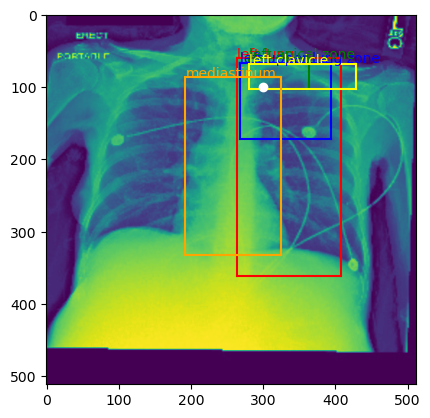

In [48]:
image = test_loader.dataset[4]['image'].squeeze(0)
box = test_loader.dataset[4]['bbox_coordinates']*2

def find_box_containing_point(point, boxes):
    box_inds = []
    for i in range(len(boxes)):
        box = boxes[i]
        if point[0] >= box[0] and point[0] <= box[2] and point[1] >= box[1] and point[1] <= box[3]:
            box_inds.append(i)
    return box_inds

print(find_box_containing_point([300,100], box))
viz_image(4, find_box_containing_point([300,100], box), point=[300,100])

### Find closest box

[18  0  1]


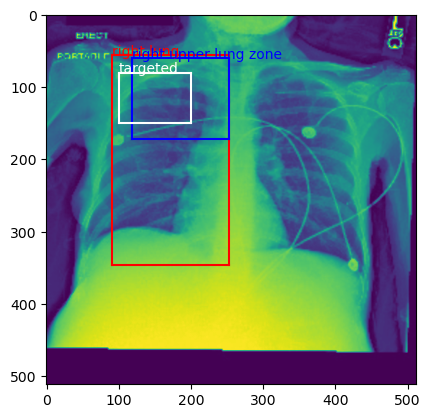

In [74]:
import numpy as np

def calculate_similarity(target_box, boxes):
    target_area = (target_box[2] - target_box[0]) * (target_box[3] - target_box[1])
    target_center = [(target_box[0] + target_box[2]) / 2, (target_box[1] + target_box[3]) / 2]
    
    max_distance = np.sqrt((target_box[2] - target_box[0])**2 + (target_box[3] - target_box[1])**2)
    
    scores = []
    
    for box in boxes:
        # Calculate overlap
        x_overlap = max(0, min(target_box[2], box[2]) - max(target_box[0], box[0]))
        y_overlap = max(0, min(target_box[3], box[3]) - max(target_box[1], box[1]))
        overlap_area = x_overlap * y_overlap
        overlap_score = overlap_area / target_area
        
        # Calculate size similarity
        box_area = (box[2] - box[0]) * (box[3] - box[1])
        size_score = min(target_area, box_area) / max(target_area, box_area)
        
        # Calculate proximity
        box_center = [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]
        distance = np.sqrt((box_center[0] - target_center[0])**2 + (box_center[1] - target_center[1])**2)
        proximity_score = 1 - (distance / max_distance)
        
        # Calculate final score
        final_score = (2 * overlap_score + size_score + proximity_score) / 4
        scores.append(final_score)
    
    return scores

def find_most_similar_boxes(target_box, boxes, num_boxes=3):
    scores = calculate_similarity(target_box, boxes)
    # get indices of top 3 scores
    top_three_inds = np.argsort(scores)[-num_boxes:]
    return top_three_inds

target_box = [100,80,200,150]
print(find_most_similar_boxes(target_box, box))
viz_image(4, find_most_similar_boxes(target_box, box, 2),  target_box=target_box)



# Confirm abnormal boxes

False